In [1]:
import requests
import os
import os.path
import pandas as pd
import matplotlib.pyplot as plt

# 一、获取数据
## 1. 获取各文件下载地址

In [ ]:
url_base="http://yang.lzu.edu.cn/data/"
url_index = 'index.txt'
print("Downloading index of data>>>>>>")
index_content = requests.get(url_base+url_index).content

## 2. 获取到地址，程序自动下载

In [ ]:
for url_data in index_content.decode("utf-8").split("\n"):
    url_data = "." + url_data if not url_data.startswith(".") else url_data #在文件路径中，有的路径前面没有"."，需要单独处理
    if not url_data.endswith(".json"):   #根据是否有“.josn”,来区分这是一个样本的地址还是一个目录
        if not os.path.exists(url_data):  #判断本地是否存在这个文件夹，不存在就创建对应文件夹
            print("Making a new folder...")  
            print(url_data)
            os.makedirs(url_data)
        else:
            print("Folder exists...")
            print(url_data)
    else:
        data = requests.get(url_base + url_data[1:])
        print(url_data)
        with open(url_data, "wb") as code:
             code.write(data.content)

# 二、数据预处理

### 1.读取全部数据，处理成一个容易管理的数据结构

In [60]:
def read_sensor_data(dataset_path):
    dataset={}
    for s in ["gyroscope","accelerometer","device_motion"]:
        for m in ["anxiety","health"]:
            datapath  = os.path.join(dataset_path,s,m,"female")
            fileslist = os.listdir(datapath)
            for filename in fileslist:
                filepath = os.path.join(datapath,filename)
                dataset.setdefault(filename.split("_")[1],{})
                dataset[filename.split("_")[1]]["group"]=m
                dataset[filename.split("_")[1]]["datetime"]=filename.split("_")[0]
                dataset[filename.split("_")[1]]["sex"]="female"
                dataset[filename.split("_")[1]][s]=pd.read_json(filepath)
    return dataset

dataset = read_sensor_data(".")   #把全部数据组织成了一个字典

# 字典数据结构为：
# {"308": {"group":
#         "datetime":'20191107191800',
#         "sex":'female',
#         "gyroscope":  json data of gyroscope,
#         "accelerometer": json data of gyroscope,
#         "device_motion": json data of gyroscope,
#         }
#  "309":{......}
#  ...... 
# }


### 2.预处理
**分别处理三个传感器的数据，保留正常的样本，分别形成三个带标签的数据集**

### ①缺失数据处理
有些用户手机没有陀螺仪导致收集到的数据是空的，这种数据缺失很难补全，所以对样本做直接删除处理    
**同时，根据不同传感器将数据放入不同数据集合中**

In [153]:
gyroscope_set = {}    #形成了三个带标签的无缺失的传感器数据的数据集
accelerometer_set = {}
device_motion_set = {}
for k,v in dataset.items():
    if "gyroscope" in v.keys() and not len(v["gyroscope"])==0:
        gyroscope_set.setdefault(k,{"data":v["gyroscope"],})
        gyroscope_set[k]["group"]=v["group"]
        gyroscope_set[k]["sex"]=v["sex"]
    if "accelerometer" in v.keys() and not len(v["accelerometer"])==0:
        accelerometer_set.setdefault(k,{"data":v["accelerometer"],})
        accelerometer_set[k]["group"]=v["group"]
        accelerometer_set[k]["sex"]=v["sex"]
    if "device_motion" in v.keys() and not len(v["device_motion"])==0:
        device_motion_set.setdefault(k,{"data":v["device_motion"],})
        device_motion_set[k]["group"]=v["group"]
        device_motion_set[k]["sex"]=v["sex"]
        
#结构为：
# {'id':{"data"：json data
#        "group": "anxiety"
#        "sex":"female"
#       }
#   ....
# }

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001CDA08AA948>,
      dtype=object)

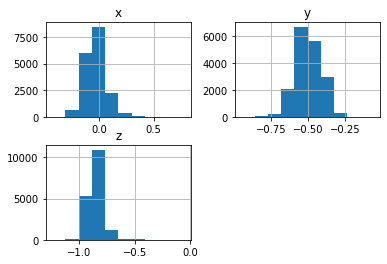

In [72]:
list(accelerometer_set.values())[0]["data"].hist()

### ②异常数据处理
各传感器数据记录频率为5hz，由此可以计算用户的答题时长

**1）时间异常**

**首先观察数据，观察数据分布情况**

1544.8435897435895


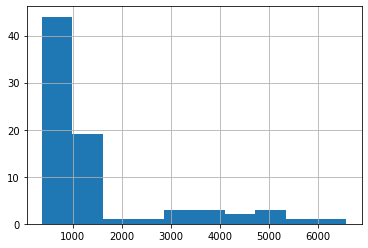

In [142]:
def show_time_hist(sensordata:dict):
    timelist = []
    for k,v in accelerometer_set.items():
        data = v["data"]
        timelist.append(data.shape[0]/5)

    timeseries = pd.Series(timelist)
    print(timeseries.mean())       #可以看出平均答题时长在30分钟左右
    timeseries.hist()              #由图可以看出大多数答题时长在1小时以下

show_time_hist(accelerometer_set)
#show_time_hist(gyroscope_set)
#show_time_hist(device_motion_set)

**删除时间超出平均时长3倍的样本**

In [129]:
def time_abnormal_handle(sensordata:dict):
    t = {}
    for k,v in sensordata.items():
        data = v["data"]
        if not data.shape[0]/5 > 3*timeseries.mean():
            t[k]=v
    return t

1273.3972602739725


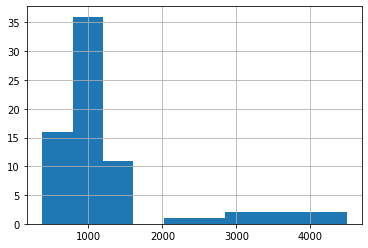

In [154]:
gyroscope_set =  time_abnormal_handle(gyroscope_set)
accelerometer_set = time_abnormal_handle(accelerometer_set)
device_motion_set = time_abnormal_handle(device_motion_set)
show_time_hist(accelerometer_set)
#show_time_hist(gyroscope_set)
#show_time_hist(device_motion_set)

**2）行为异常**

有些用户没有按要求测试，将手机放到了桌面上，导致测试到的数据波动过小，不能体现用户行为状态，这种数据做删除处理。  
有些数据波动过大，可能与传感器性能不同有关，此类数据也做删除。

首先计算出各轴的方差和后，作图观察数据

In [138]:
def show_action_hist(sensordata:dict):
    var_list = []
    for k,v in sensordata.items():
        varsum = v["data"].iloc[:,0].var()+v["data"].iloc[:,1].var()+v["data"].iloc[:,2].var()
        var_list.append(varsum)
    return pd.Series(var_list)

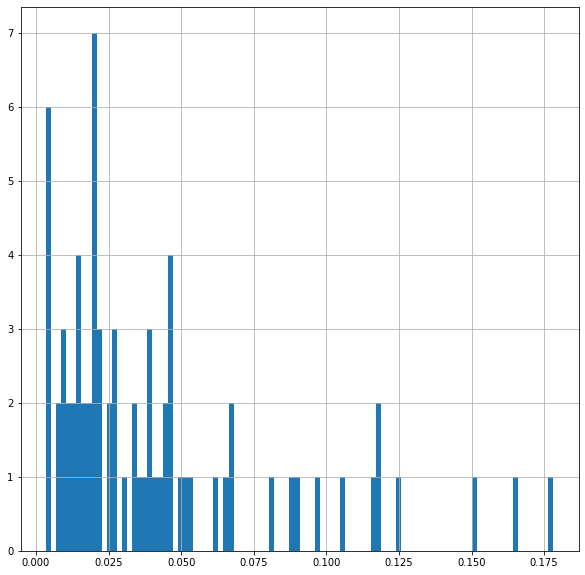

In [156]:
show_action_hist(accelerometer_set).hist(figsize=(10,10),bins=100)   

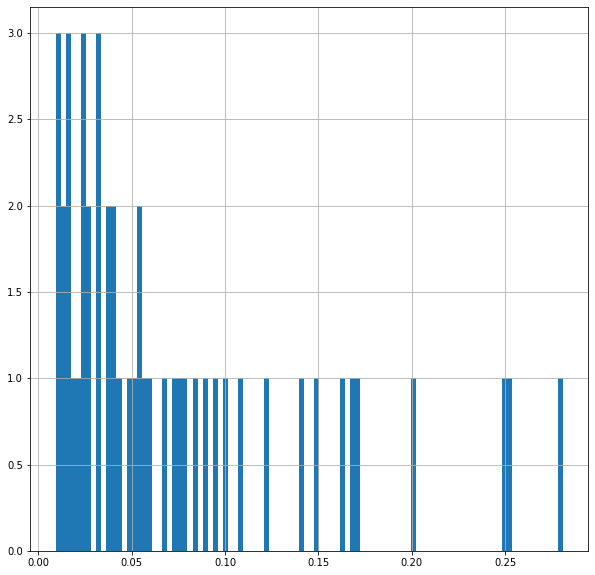

In [152]:
show_action_hist(gyroscope_set).hist(figsize=(10,10),bins=100) 

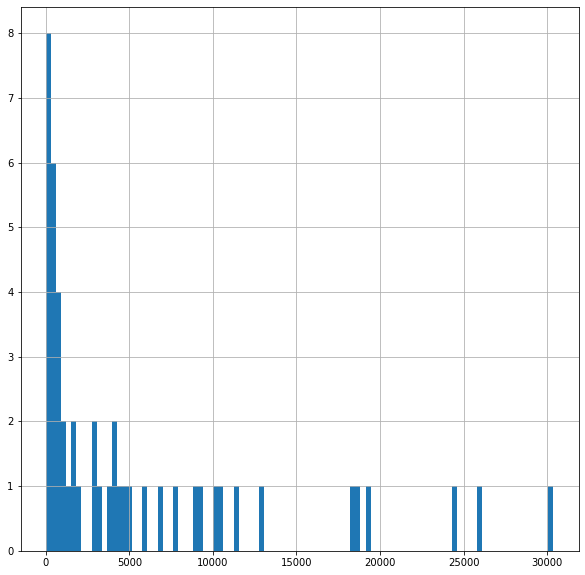

In [157]:
show_action_hist(device_motion_set).hist(figsize=(10,10),bins=100) 

由直方图可以观察出accelerometer,gyroscope,device_motion的异常点

In [144]:
def action_abnormal_handle(sensordata:dict,limit):
    t={}
    for k,v in sensordata.items():
        varsum = v["data"].iloc[:,0].var()+v["data"].iloc[:,1].var()+v["data"].iloc[:,2].var()
        if varsum < limit:
            t[k]=v
    return t

根据由图观察出的不同的限制值，去掉不同传感器的异常值

In [159]:
gyroscope_set = action_abnormal_handle(gyroscope_set,0.35)
accelerometer_set = action_abnormal_handle(accelerometer_set,1.5)
device_motion_set = action_abnormal_handle(device_motion_set,25000)

**效果如图**

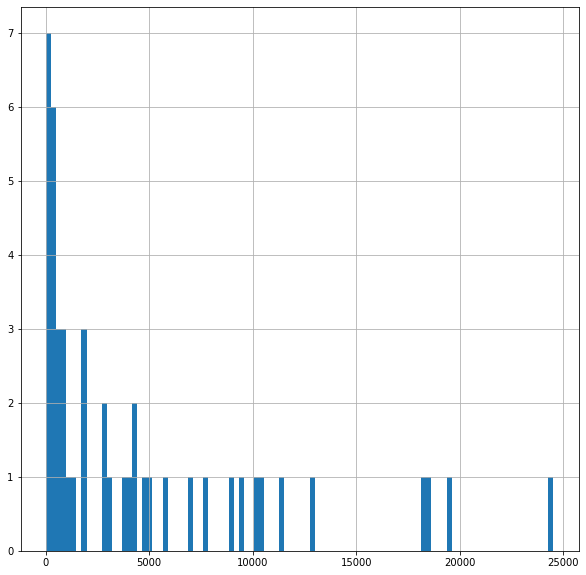

In [160]:
show_action_hist(device_motion_set).hist(figsize=(10,10),bins=100) 

### ③为每个样本添加时间属性
添加时间属性，提供一个特征维度

In [161]:
def add_time_attr(sensordata:dict):
    t={}
    for k,v in accelerometer_set.items():
        data = v["data"]
        v["time"] = data.shape[0]/5
        t[k]=v
    return t

In [162]:
accelerometer_set = add_time_attr(accelerometer_set)
gyroscope_set = add_time_attr(gyroscope_set)
device_motion_set = add_time_attr(device_motion_set)

In [163]:
accelerometer_set.values()

dict_values([{'data':               x         y         z
0     -0.111657 -0.640157 -0.741568
1     -0.145579 -0.633443 -0.756502
2     -0.093783 -0.627508 -0.732474
3     -0.089605 -0.595811 -0.811558
4     -0.092811 -0.590913 -0.798304
...         ...       ...       ...
17810 -0.169556 -0.393245 -0.868659
17811 -0.161640 -0.396743 -0.863177
17812 -0.152435 -0.392717 -0.893308
17813 -0.168031 -0.417798 -0.847383
17814 -0.180208 -0.367067 -1.005732

[17815 rows x 3 columns], 'group': 'anxiety', 'sex': 'female', 'time': 3563.0}, {'data':              x         y         z
0     0.087726 -0.437346 -0.834288
1     0.069696 -0.437346 -0.833522
2     0.068979 -0.439574 -0.838669
3     0.074150 -0.450562 -0.829547
4     0.104677 -0.471631 -0.821599
...        ...       ...       ...
4798  0.259245 -0.230153 -0.890193
4799  0.265782 -0.219690 -0.892323
4800  0.267818 -0.217870 -0.892899
4801  0.268846 -0.216266 -0.894359
4802  0.271408 -0.219163 -0.894789

[4803 rows x 3 columns], 'group': '

## 三、处理结果
#### 经过数据读取，数据结构的组织，数据缺失值异常值处理，时间属性的添加这些步骤，   
#### 得到了以下数据

In [165]:
accelerometer_set

{'308': {'data':               x         y         z
  0     -0.111657 -0.640157 -0.741568
  1     -0.145579 -0.633443 -0.756502
  2     -0.093783 -0.627508 -0.732474
  3     -0.089605 -0.595811 -0.811558
  4     -0.092811 -0.590913 -0.798304
  ...         ...       ...       ...
  17810 -0.169556 -0.393245 -0.868659
  17811 -0.161640 -0.396743 -0.863177
  17812 -0.152435 -0.392717 -0.893308
  17813 -0.168031 -0.417798 -0.847383
  17814 -0.180208 -0.367067 -1.005732
  
  [17815 rows x 3 columns],
  'group': 'anxiety',
  'sex': 'female',
  'time': 3563.0},
 '558': {'data':              x         y         z
  0     0.087726 -0.437346 -0.834288
  1     0.069696 -0.437346 -0.833522
  2     0.068979 -0.439574 -0.838669
  3     0.074150 -0.450562 -0.829547
  4     0.104677 -0.471631 -0.821599
  ...        ...       ...       ...
  4798  0.259245 -0.230153 -0.890193
  4799  0.265782 -0.219690 -0.892323
  4800  0.267818 -0.217870 -0.892899
  4801  0.268846 -0.216266 -0.894359
  4802  0.271408

In [166]:
gyroscope_set 

{'308': {'data':               x         y         z
  0     -0.111657 -0.640157 -0.741568
  1     -0.145579 -0.633443 -0.756502
  2     -0.093783 -0.627508 -0.732474
  3     -0.089605 -0.595811 -0.811558
  4     -0.092811 -0.590913 -0.798304
  ...         ...       ...       ...
  17810 -0.169556 -0.393245 -0.868659
  17811 -0.161640 -0.396743 -0.863177
  17812 -0.152435 -0.392717 -0.893308
  17813 -0.168031 -0.417798 -0.847383
  17814 -0.180208 -0.367067 -1.005732
  
  [17815 rows x 3 columns],
  'group': 'anxiety',
  'sex': 'female',
  'time': 3563.0},
 '558': {'data':              x         y         z
  0     0.087726 -0.437346 -0.834288
  1     0.069696 -0.437346 -0.833522
  2     0.068979 -0.439574 -0.838669
  3     0.074150 -0.450562 -0.829547
  4     0.104677 -0.471631 -0.821599
  ...        ...       ...       ...
  4798  0.259245 -0.230153 -0.890193
  4799  0.265782 -0.219690 -0.892323
  4800  0.267818 -0.217870 -0.892899
  4801  0.268846 -0.216266 -0.894359
  4802  0.271408

In [167]:
device_motion_set

{'308': {'data':               x         y         z
  0     -0.111657 -0.640157 -0.741568
  1     -0.145579 -0.633443 -0.756502
  2     -0.093783 -0.627508 -0.732474
  3     -0.089605 -0.595811 -0.811558
  4     -0.092811 -0.590913 -0.798304
  ...         ...       ...       ...
  17810 -0.169556 -0.393245 -0.868659
  17811 -0.161640 -0.396743 -0.863177
  17812 -0.152435 -0.392717 -0.893308
  17813 -0.168031 -0.417798 -0.847383
  17814 -0.180208 -0.367067 -1.005732
  
  [17815 rows x 3 columns],
  'group': 'anxiety',
  'sex': 'female',
  'time': 3563.0},
 '558': {'data':              x         y         z
  0     0.087726 -0.437346 -0.834288
  1     0.069696 -0.437346 -0.833522
  2     0.068979 -0.439574 -0.838669
  3     0.074150 -0.450562 -0.829547
  4     0.104677 -0.471631 -0.821599
  ...        ...       ...       ...
  4798  0.259245 -0.230153 -0.890193
  4799  0.265782 -0.219690 -0.892323
  4800  0.267818 -0.217870 -0.892899
  4801  0.268846 -0.216266 -0.894359
  4802  0.271408

结构为
{'id':{"data"：  json sensor data    
        "group": "anxiety"    
        "sex":   "female"    
        "time":  1234.21   
      }    
   ....    
}